# Resolução de Problema de Aprendizado Não Supervisionado: Clusterização de Comportamento de Compras Online

## 1. Importação dos Dados

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage

# Para ignorar warnings que podem aparecer durante o t-SNE ou outras operações
import warnings
warnings.filterwarnings('ignore')

# Definir estilo para os gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

---

## 2. Seleção do Conjunto de Dados

Para este trabalho de clusterização, escolhemos o **Online Shoppers Purchasing Intention Dataset** do UCI Machine Learning Repository. Este dataset é ideal para o problema de aprendizado não supervisionado por várias razões:

* **Tamanho:** Contém 12.330 amostras, superando o requisito mínimo de 1.000 amostras.
* **Número de Features:** Possui 18 características, atendendo ao requisito de no mínimo 6 features.
* **Ausência de Target para Clusterização:** Embora o dataset contenha uma coluna `Revenue` que poderia ser usada como *target* em um problema de classificação, para o propósito de clusterização, esta coluna será ignorada ou removida, tornando o problema puramente não supervisionado.
* **Facilidade para Iniciantes:** As features são relativamente intuitivas, e o dataset oferece uma boa mistura de dados numéricos e categóricos, proporcionando um excelente exercício de pré-processamento.
* **Disponibilidade Pública:** O dataset é publicamente acessível através do UCI Machine Learning Repository.

O objetivo será clusterizar sessões de usuários de e-commerce com base em seu comportamento de navegação e atributos, a fim de identificar grupos distintos de clientes ou padrões de interação.

---

### 2.1 Primeiro, vamos carregar o dataset `online_shoppers_intention.csv` para um DataFrame do pandas.

In [111]:
# Caminho para o arquivo CSV (assumindo que está no mesmo diretório do notebook)
file_path = 'online_shoppers_intention.csv'
df = pd.read_csv(file_path)

feature_translations = {
    'Administrative': 'Paginas_Administrativas',
    'Administrative_Duration': 'Duracao_Administrativas',
    'Informational': 'Paginas_Informacionais',
    'Informational_Duration': 'Duracao_Informacionais',
    'ProductRelated': 'Paginas_Relacionadas_Produto',
    'ProductRelated_Duration': 'Duracao_Relacionadas_Produto',
    'BounceRates': 'Taxa_Rejeicao',
    'ExitRates': 'Taxa_Saida',
    'PageValues': 'Valor_Pagina',
    'SpecialDay': 'Dia_Especial',
    'Month': 'Mes',
    'OperatingSystems': 'Sistema_Operacional',
    'Browser': 'Navegador',
    'Region': 'Regiao',
    'TrafficType': 'Tipo_Trafego',
    'VisitorType': 'Tipo_Visitante',
    'Weekend': 'Fim_de_Semana',
    'Revenue': 'Receita' # Será removida/ignorada para clusterização
}

# Renomear as colunas usando o dicionário de tradução
df.rename(columns=feature_translations, inplace=True)

print("Dados importados com sucesso!")
print(f"Shape do DataFrame: {df.shape}")

Dados importados com sucesso!
Shape do DataFrame: (12330, 18)


---

## 3. Análise dos Dados (Exploratory Data Analysis - EDA)

Nesta seção, exploraremos a estrutura e o conteúdo do dataset para entender suas características, identificar valores ausentes, tipos de dados e distribuições.

In [112]:
print("### Primeiras 5 linhas do DataFrame ###")
print(df.head())

print("\n### Informações gerais do DataFrame ###")
df.info()

print("\n### Estatísticas descritivas para features numéricas ###")
print(df.describe())

print("\n### Contagem de valores nulos por coluna ###")
print(df.isnull().sum())

# Análise de features categóricas
print("\n### Valores únicos e suas contagens para features categóricas ###")
for col in df.select_dtypes(include='object').columns:
    print(f"\nColuna '{col}':")
    print(df[col].value_counts())

# A coluna 'Revenue' será o nosso 'target' se fosse classificação. Para clusterização, vamos ignorá-la.
# No entanto, vamos verificar sua distribuição para entender o dataset completo.
print("\n### Distribuição da coluna 'Revenue' (para compreensão, será ignorada na clusterização) ###")
print(df['Receita'].value_counts())

### Primeiras 5 linhas do DataFrame ###
   Paginas_Administrativas  Duracao_Administrativas  Paginas_Informacionais  \
0                        0                      0.0                       0   
1                        0                      0.0                       0   
2                        0                      0.0                       0   
3                        0                      0.0                       0   
4                        0                      0.0                       0   

   Duracao_Informacionais  Paginas_Relacionadas_Produto  \
0                     0.0                             1   
1                     0.0                             2   
2                     0.0                             1   
3                     0.0                             2   
4                     0.0                            10   

   Duracao_Relacionadas_Produto  Taxa_Rejeicao  Taxa_Saida  Valor_Pagina  \
0                      0.000000           0.20        

**Observações da EDA:**

* O dataset possui 12.330 amostras e 18 colunas.
* Há uma mistura de tipos de dados: `int64`, `float64` e `object` (categóricos).
* Algumas colunas como `Administrative_Duration`, `Informational_Duration`, `ProductRelated_Duration`, `PageValues`, `SpecialDay`, `Month`, `OperatingSystems`, `Browser`, `Region`, `TrafficType`, `VisitorType` e `Weekend` têm o tipo `object` ou `bool` (`Weekend`, `Revenue`), mas algumas deveriam ser numéricas ou tratadas como categóricas. `Revenue` e `Weekend` são booleanas (`True`/`False`).
* Há valores nulos nas colunas `Administrative`, `Administrative_Duration`, `Informational`, `Informational_Duration`, `ProductRelated` e `ProductRelated_Duration`.
* A coluna `Revenue` é booleana (`True`/`False`) e indica se a sessão resultou em uma compra. Para clusterização, esta coluna será **removida**.

---

## 4. Pré-processamento dos Dados

Esta etapa é crucial para preparar os dados para os algoritmos de clusterização. Inclui o tratamento de valores faltantes, outliers e a transformação de features categóricas e a normalização.

### 4.1 Remoção da Coluna 'Revenue'

Como estamos lidando com um problema de aprendizado não supervisionado (clusterização), a coluna `Revenue` (que seria um *target*) deve ser removida.

In [113]:
df_processed = df.copy()
df_processed = df_processed.drop('Receita', axis=1)

print(f"Shape do DataFrame após remover 'Revenue': {df_processed.shape}")

Shape do DataFrame após remover 'Revenue': (12330, 17)


### 4.2 Tratamento de Valores Faltantes

As colunas `Administrative`, `Administrative_Duration`, `Informational`, `Informational_Duration`, `ProductRelated` e `ProductRelated_Duration` possuem valores nulos. Para este trabalho, optaremos por preencher os valores nulos com a **mediana** de suas respectivas colunas, pois a mediana é menos sensível a outliers do que a média.

In [114]:
# Colunas com valores nulos
cols_with_missing = ['Paginas_Administrativas', 'Duracao_Administrativas', 'Paginas_Informacionais',
                     'Duracao_Informacionais', 'Paginas_Relacionadas_Produto', 'Duracao_Relacionadas_Produto']

for col in cols_with_missing:
    median_val = df_processed[col].median()
    df_processed[col].fillna(median_val, inplace=True)

print("\n### Contagem de valores nulos após tratamento ###")
print(df.isnull().sum()) # Usando df aqui para verificar nulos antes da remoção da coluna 'Receita'


### Contagem de valores nulos após tratamento ###
Paginas_Administrativas         0
Duracao_Administrativas         0
Paginas_Informacionais          0
Duracao_Informacionais          0
Paginas_Relacionadas_Produto    0
Duracao_Relacionadas_Produto    0
Taxa_Rejeicao                   0
Taxa_Saida                      0
Valor_Pagina                    0
Dia_Especial                    0
Mes                             0
Sistema_Operacional             0
Navegador                       0
Regiao                          0
Tipo_Trafego                    0
Tipo_Visitante                  0
Fim_de_Semana                   0
Receita                         0
dtype: int64


### 4.3 Engenharia de Features

Nesta etapa, criaremos novas features a partir das existentes para potencialmente capturar padrões mais complexos no comportamento de compra.

In [115]:
# Colunas que são puramente numéricas (incluindo Fim_de_Semana que já foi convertido para int)
original_numeric_cols = [
    'Paginas_Administrativas', 'Duracao_Administrativas', 'Paginas_Informacionais', 'Duracao_Informacionais',
    'Paginas_Relacionadas_Produto', 'Duracao_Relacionadas_Produto', 'Taxa_Rejeicao', 'Taxa_Saida', 'Valor_Pagina',
    'Dia_Especial', 'Fim_de_Semana' 
]

# Criamos uma cópia do DataFrame apenas com as colunas numéricas para a engenharia
df_numeric_part = df_processed[original_numeric_cols].copy()

epsilon = 1e-6 # Para evitar divisão por zero

df_numeric_part['Taxa_Paginas_por_Duracao_Admin'] = df_numeric_part['Paginas_Administrativas'] / (df_numeric_part['Duracao_Administrativas'] + epsilon)
df_numeric_part['Taxa_Paginas_por_Duracao_Info'] = df_numeric_part['Paginas_Informacionais'] / (df_numeric_part['Duracao_Informacionais'] + epsilon)
df_numeric_part['Taxa_Paginas_por_Duracao_Produto'] = df_numeric_part['Paginas_Relacionadas_Produto'] / (df_numeric_part['Duracao_Relacionadas_Produto'] + epsilon)

df_numeric_part['Total_Paginas_Visitadas'] = df_numeric_part['Paginas_Administrativas'] + df_numeric_part['Paginas_Informacionais'] + df_numeric_part['Paginas_Relacionadas_Produto']
df_numeric_part['Total_Duracao'] = df_numeric_part['Duracao_Administrativas'] + df_numeric_part['Duracao_Informacionais'] + df_numeric_part['Duracao_Relacionadas_Produto']

# Proporção de tempo gasto em páginas de produto (se Total_Duracao for zero, será NaN, que será tratado pela padronização)
df_numeric_part['Proporcao_Tempo_Produto'] = df_numeric_part['Duracao_Relacionadas_Produto'] / (df_numeric_part['Total_Duracao'] + epsilon)

# Tratar possíveis NaNs/Infinitos resultantes da engenharia de features (divisão por zero)
for col in ['Taxa_Paginas_por_Duracao_Admin', 'Taxa_Paginas_por_Duracao_Info', 'Taxa_Paginas_por_Duracao_Produto', 'Proporcao_Tempo_Produto']:
    df_numeric_part[col] = df_numeric_part[col].replace([np.inf, -np.inf], np.nan)
    df_numeric_part[col].fillna(0, inplace=True) # Preencher NaNs com 0 para estas novas features

print("\n### Primeiras linhas do DataFrame da parte numérica após Engenharia de Features ###")
print(df_numeric_part.head())
print(f"Shape do DataFrame numérico após Engenharia de Features: {df_numeric_part.shape}")


### Primeiras linhas do DataFrame da parte numérica após Engenharia de Features ###
   Paginas_Administrativas  Duracao_Administrativas  Paginas_Informacionais  \
0                        0                      0.0                       0   
1                        0                      0.0                       0   
2                        0                      0.0                       0   
3                        0                      0.0                       0   
4                        0                      0.0                       0   

   Duracao_Informacionais  Paginas_Relacionadas_Produto  \
0                     0.0                             1   
1                     0.0                             2   
2                     0.0                             1   
3                     0.0                             2   
4                     0.0                            10   

   Duracao_Relacionadas_Produto  Taxa_Rejeicao  Taxa_Saida  Valor_Pagina  \
0        

### 4.4 Tratamento de Outliers (Análise e Justificativa)

As features de duração e contagem de páginas (e.g., `Administrative_Duration`, `ProductRelated_Duration`, `PageValues`, `BounceRates`, `ExitRates`) podem conter outliers significativos, que são comuns em dados de comportamento de usuários (algumas sessões podem ser extremamente longas ou ter valores anormais).

Para este trabalho, em vez de remover ou transformar os outliers de forma agressiva (o que pode distorcer a distribuição real e a estrutura dos clusters para iniciantes), vamos **observar a distribuição** e confiar que a normalização (StandardScaler) mitigará parte do impacto, ao invés de realizar uma winsorização ou remoção que pode ser mais complexa. No entanto, é importante estar ciente de sua presença.

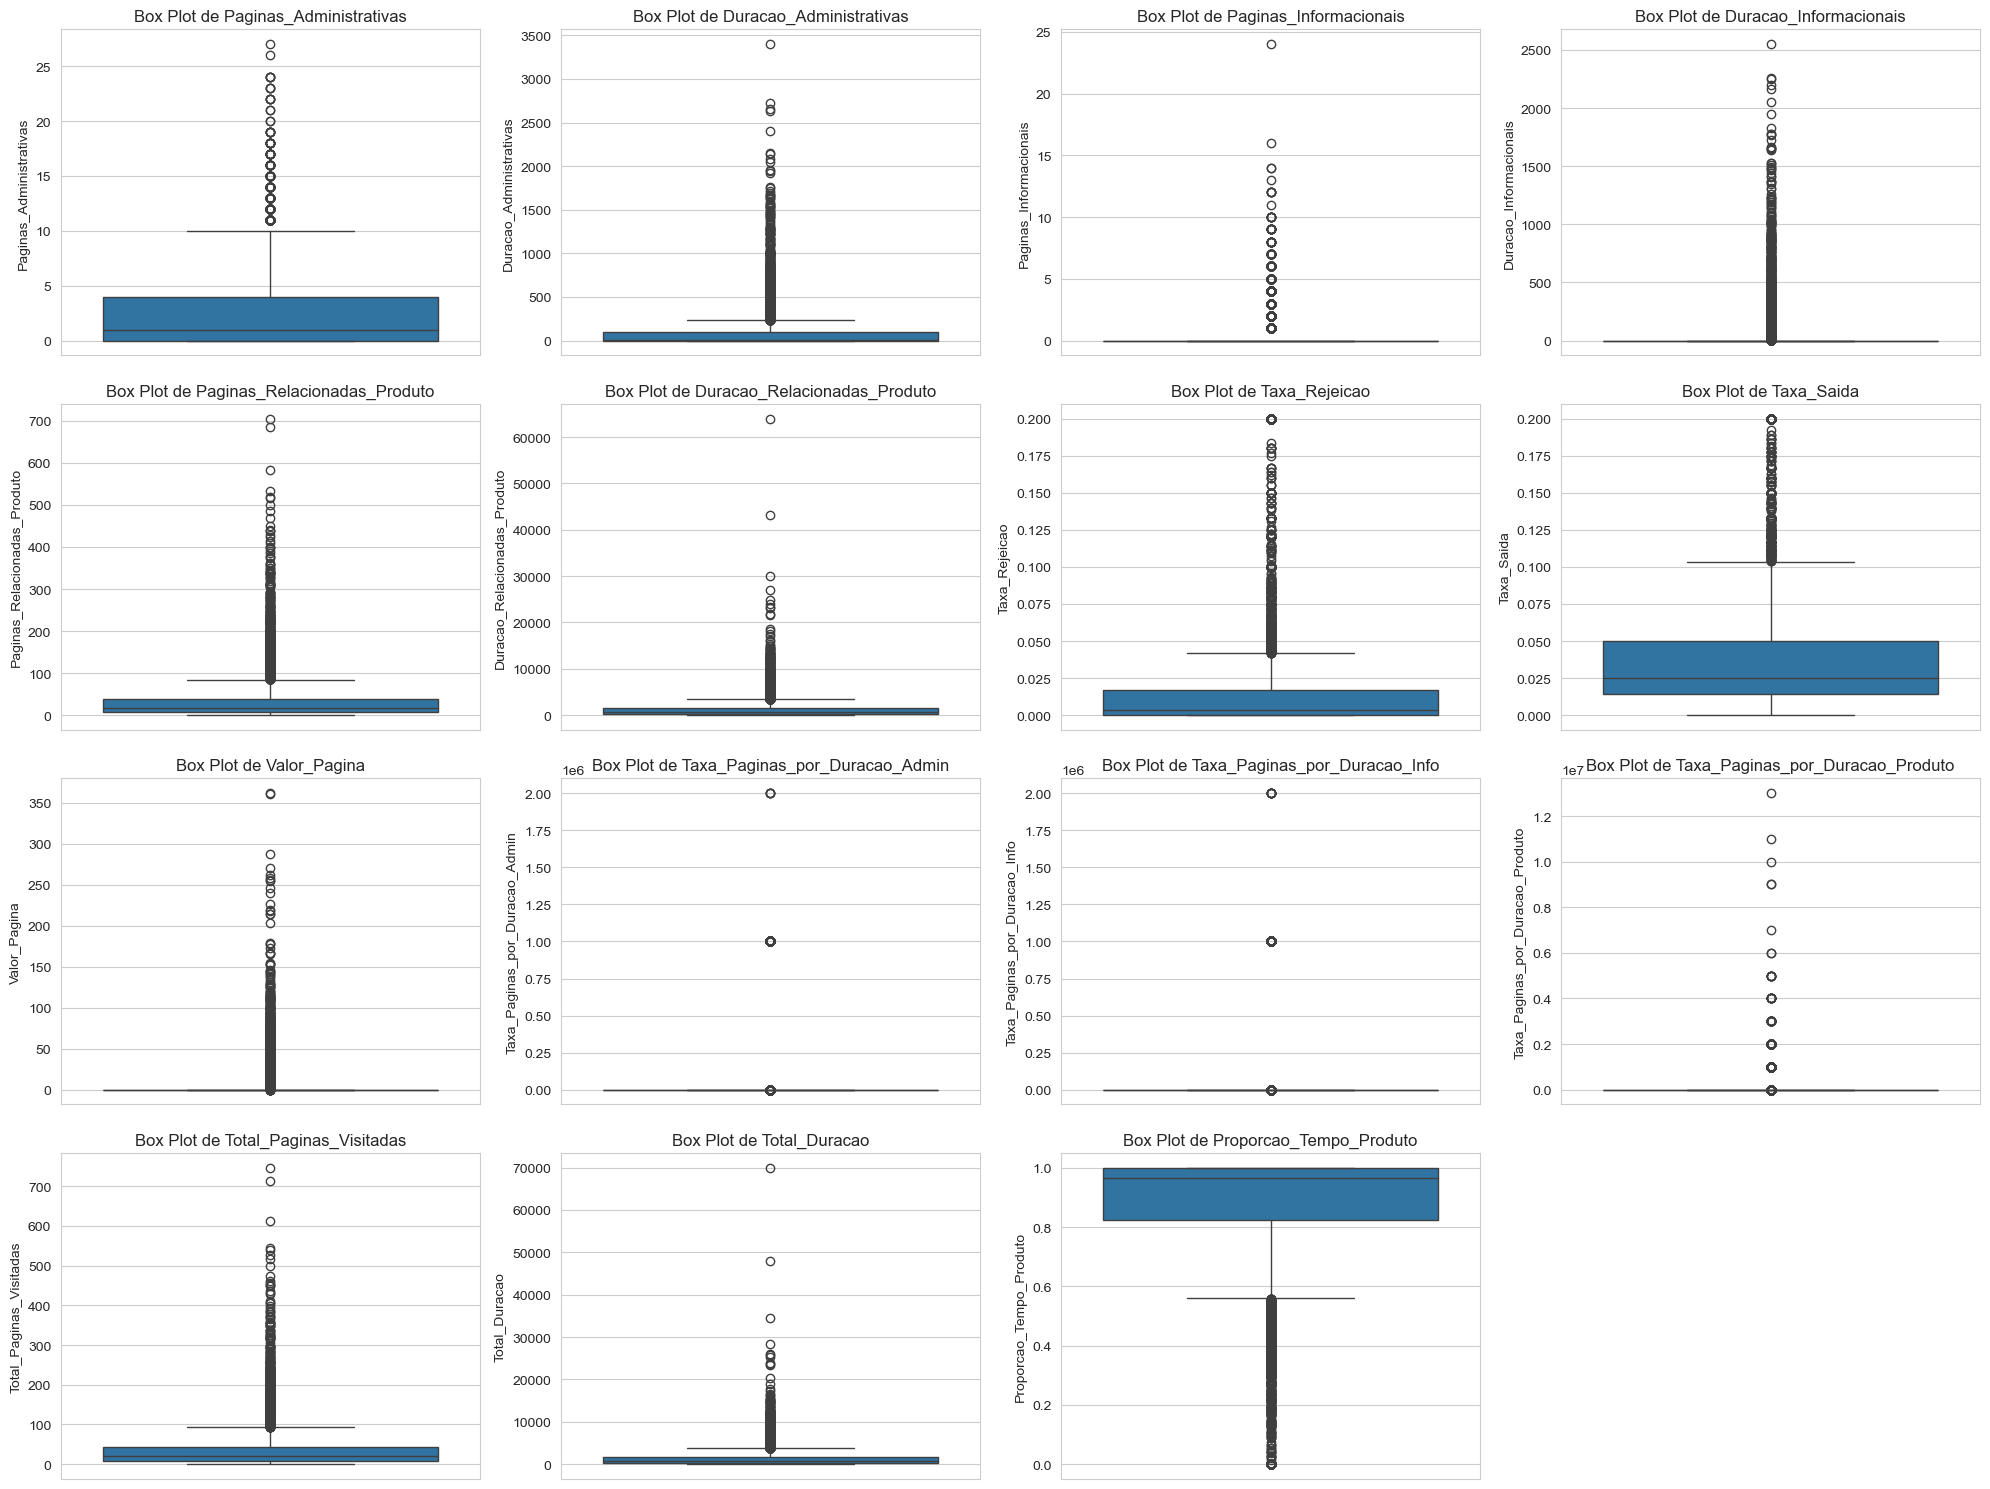


Observação: Várias features numéricas (ex: 'Duracao_Administrativas', 'Duracao_Relacionadas_Produto', 'Valor_Pagina') apresentam outliers.
Para este trabalho, a normalização será utilizada para mitigar o impacto destes, sem remoção.


In [116]:
# Visualizando Box Plots para algumas features numéricas com potencial para outliers
all_numeric_and_engineered_cols = ['Paginas_Administrativas', 'Duracao_Administrativas', 'Paginas_Informacionais', 'Duracao_Informacionais',
                'Paginas_Relacionadas_Produto', 'Duracao_Relacionadas_Produto', 'Taxa_Rejeicao', 'Taxa_Saida', 'Valor_Pagina', 
                'Taxa_Paginas_por_Duracao_Admin', 'Taxa_Paginas_por_Duracao_Info', 'Taxa_Paginas_por_Duracao_Produto',
                'Total_Paginas_Visitadas', 'Total_Duracao', 'Proporcao_Tempo_Produto']

plt.figure(figsize=(20, 15))
for i, col in enumerate(all_numeric_and_engineered_cols):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=df_numeric_part[col])
    plt.title(f'Box Plot de {col}')
plt.tight_layout()
plt.show()

print("\nObservação: Várias features numéricas (ex: 'Duracao_Administrativas', 'Duracao_Relacionadas_Produto', 'Valor_Pagina') apresentam outliers.")
print("Para este trabalho, a normalização será utilizada para mitigar o impacto destes, sem remoção.")

### 4.4.1 Codificação de Features Categóricas

As features categóricas (`Month`, `OperatingSystems`, `Browser`, `Region`, `TrafficType`, `VisitorType`, `Weekend`) precisam ser convertidas em um formato numérico. Usaremos **One-Hot Encoding** para criar novas colunas binárias para cada categoria, evitando a criação de uma ordem artificial entre elas.

A coluna `Weekend` é booleana (`True`/`False`), vamos convertê-la para `1`/`0` antes do One-Hot Encoding ou diretamente como numérica se o OHE não for aplicado. Para consistência com outras categóricas, vamos convertê-la.

In [117]:
# Colunas que devem ser tratadas como categóricas para One-Hot Encoding
# Mesmo que algumas sejam int64, as convertemos explicitamente para 'category'
categorical_cols_to_onehot = [
    'Mes', 'Sistema_Operacional', 'Navegador', 'Regiao', 'Tipo_Trafego', 'Tipo_Visitante'
]

# Criamos uma cópia do DataFrame apenas com as colunas categóricas
df_categorical_part_raw = df_processed[categorical_cols_to_onehot].copy()

# Converter explicitamente para 'category' dtype para garantir que get_dummies as trate como tal
for col in categorical_cols_to_onehot:
    df_categorical_part_raw[col] = df_categorical_part_raw[col].astype('category')

# Aplicando One-Hot Encoding
df_categorical_part = pd.get_dummies(df_categorical_part_raw, columns=categorical_cols_to_onehot, drop_first=True)

print("\n### Primeiras linhas do DataFrame da parte categórica após One-Hot Encoding ###")
print(df_categorical_part.head())
print(f"Shape do DataFrame categórico após One-Hot Encoding: {df_categorical_part.shape}")


### Primeiras linhas do DataFrame da parte categórica após One-Hot Encoding ###
   Mes_Dec  Mes_Feb  Mes_Jul  Mes_June  Mes_Mar  Mes_May  Mes_Nov  Mes_Oct  \
0    False     True    False     False    False    False    False    False   
1    False     True    False     False    False    False    False    False   
2    False     True    False     False    False    False    False    False   
3    False     True    False     False    False    False    False    False   
4    False     True    False     False    False    False    False    False   

   Mes_Sep  Sistema_Operacional_2  ...  Tipo_Trafego_13  Tipo_Trafego_14  \
0    False                  False  ...            False            False   
1    False                   True  ...            False            False   
2    False                  False  ...            False            False   
3    False                  False  ...            False            False   
4    False                  False  ...            False            Fal

### 4.5 Padronização dos Dados com StandardScaler

Algoritmos de clusterização baseados em distância, como K-Means e Clusterização Hierárquica, são sensíveis à escala das features. Features com valores maiores podem dominar o cálculo da distância. Usaremos `StandardScaler` para transformar os dados de forma que tenham média zero e variância unitária (desvio padrão de 1).

In [118]:
# --- Concatenação das Partes e Padronização Final ---

# X_final_processed é o DataFrame completo com todas as features numéricas (originais e engenheiradas)
# e as features categóricas transformadas em dummies.
X_final_processed = pd.concat([df_numeric_part, df_categorical_part], axis=1)

print("\n### Shape do DataFrame final processado (antes da padronização) ###")
print(X_final_processed.shape)
print("\n### Primeiras linhas do DataFrame final processado ###")
print(X_final_processed.head())

# Aplicação do StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final_processed)

# Transformar de volta para DataFrame para manter os nomes das colunas
X_scaled_df = pd.DataFrame(X_scaled, columns=X_final_processed.columns)

print("\nDataFrame padronizado (X_scaled_df) - Pronto para pré-clusterização e clusterização:")
print(X_scaled_df.head())
print(f"Shape: {X_scaled_df.shape}")


### Shape do DataFrame final processado (antes da padronização) ###
(12330, 74)

### Primeiras linhas do DataFrame final processado ###
   Paginas_Administrativas  Duracao_Administrativas  Paginas_Informacionais  \
0                        0                      0.0                       0   
1                        0                      0.0                       0   
2                        0                      0.0                       0   
3                        0                      0.0                       0   
4                        0                      0.0                       0   

   Duracao_Informacionais  Paginas_Relacionadas_Produto  \
0                     0.0                             1   
1                     0.0                             2   
2                     0.0                             1   
3                     0.0                             2   
4                     0.0                            10   

   Duracao_Relacionadas_Produto  

### 4.6 Visualização dos Box Plots Após StandardScaler

Agora, vamos visualizar novamente os box plots para as mesmas features numéricas, mas utilizando os dados já normalizados (`X_scaled_df`). Isso nos permitirá observar o efeito do `StandardScaler` na centralização dos dados (média próxima de zero) e na padronização da escala, mesmo na presença de outliers.


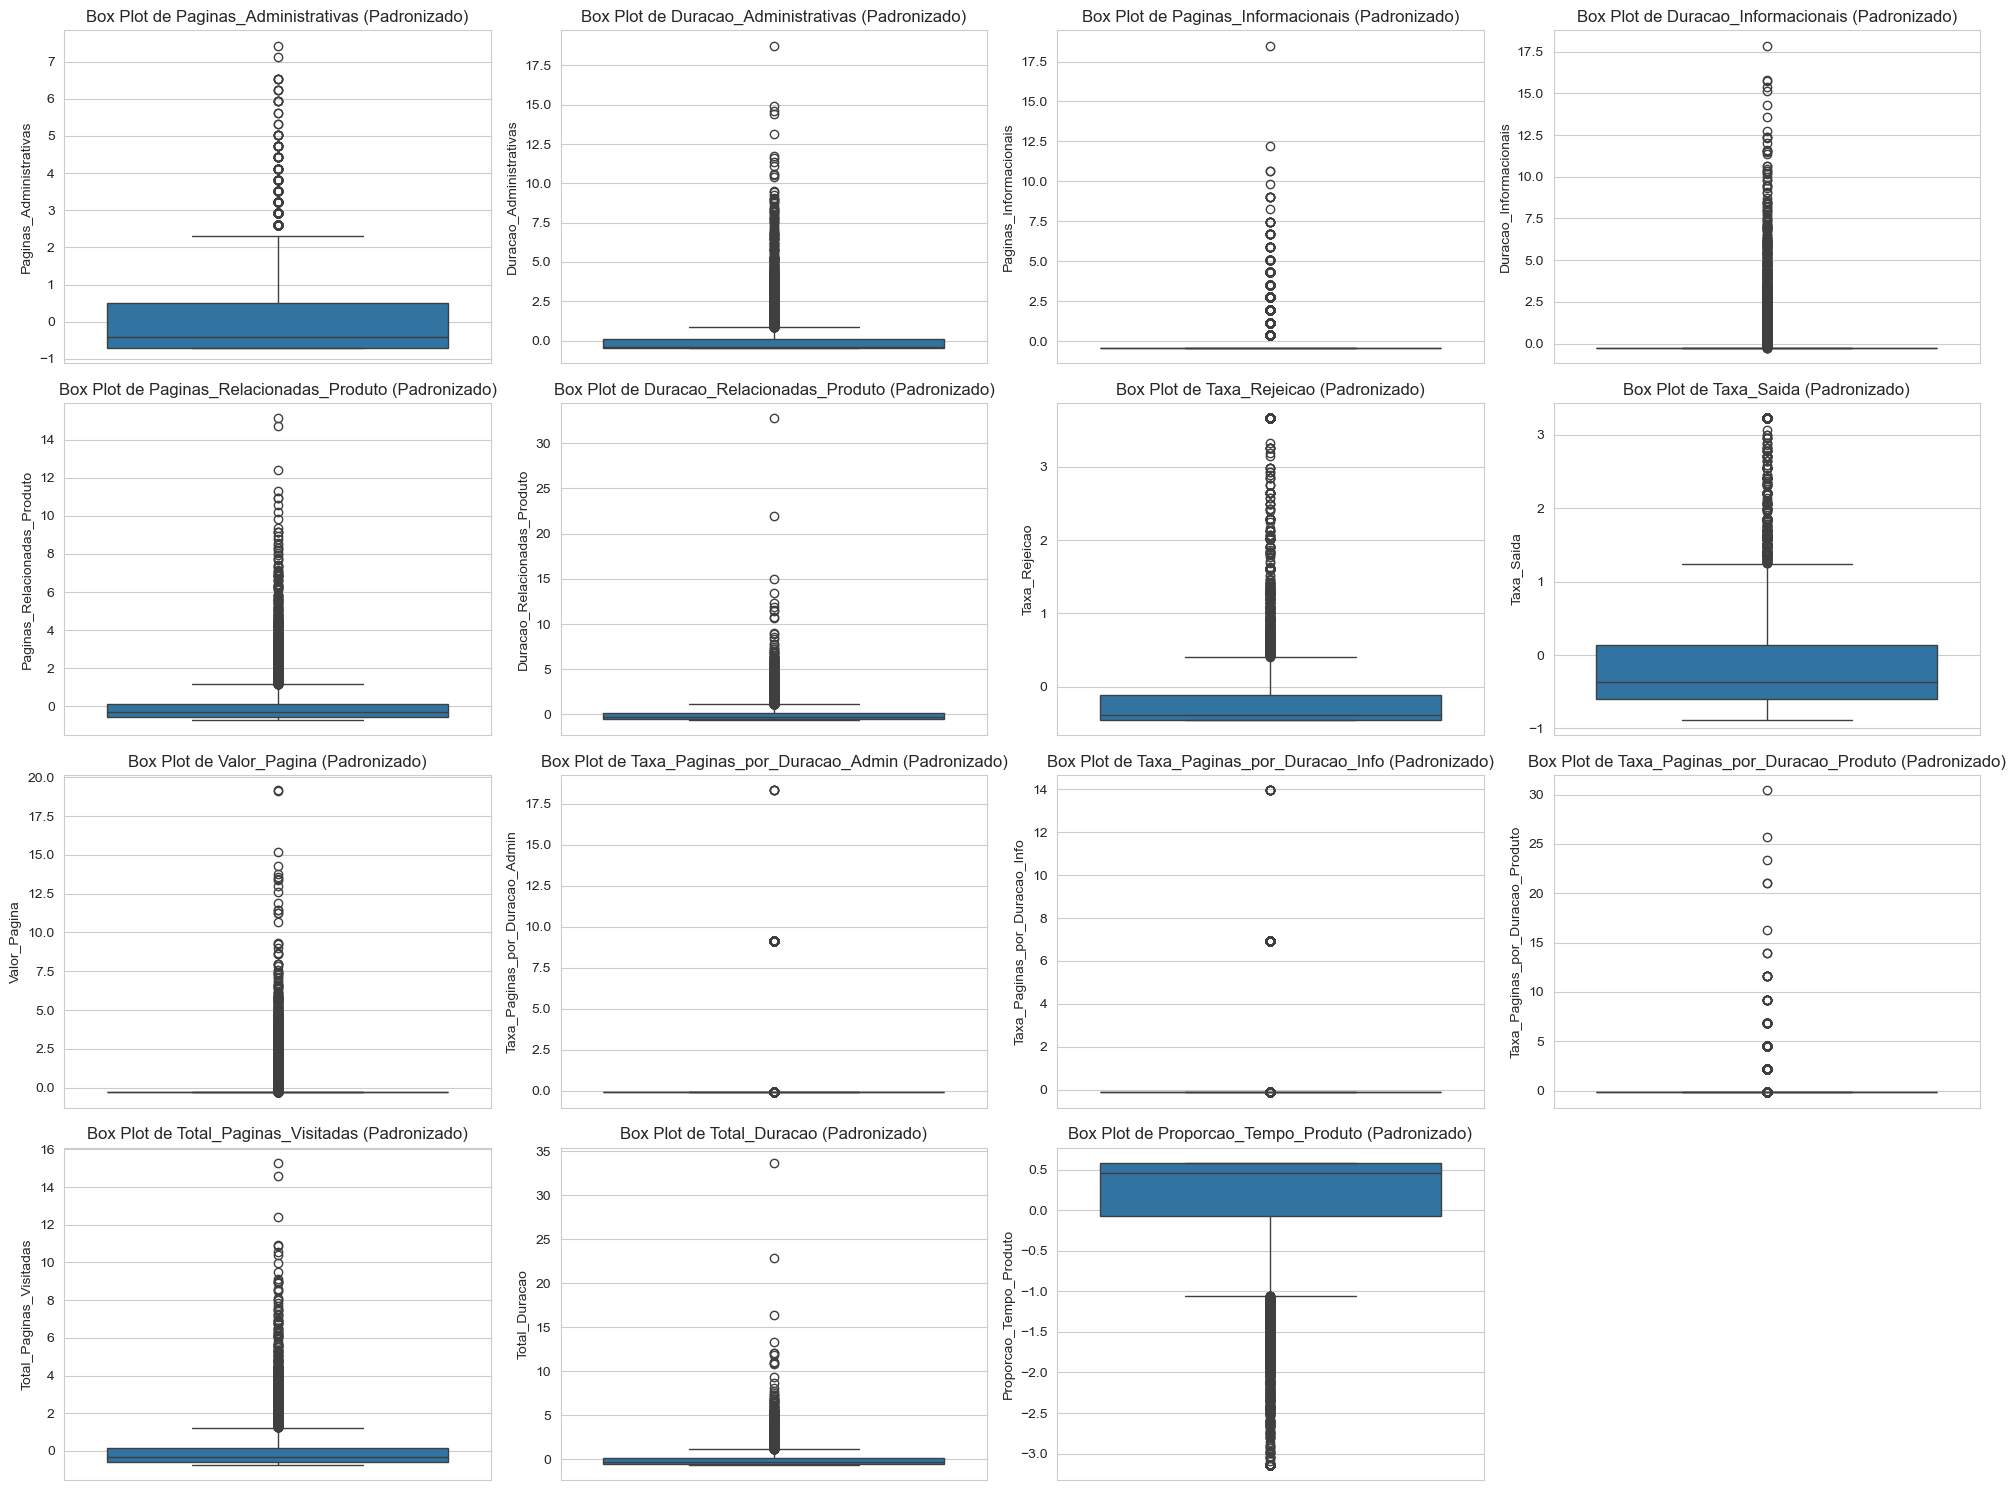


Observação: Após a padronização com StandardScaler, as features estão centralizadas em torno de zero e têm uma escala padronizada.
Os outliers ainda são visíveis, mas seu impacto na escala dos algoritmos baseados em distância é mitigado.


In [119]:
# Lista de colunas numéricas originais e novas features para visualização
all_numeric_and_engineered_cols = ['Paginas_Administrativas', 'Duracao_Administrativas', 'Paginas_Informacionais', 'Duracao_Informacionais',
                'Paginas_Relacionadas_Produto', 'Duracao_Relacionadas_Produto', 'Taxa_Rejeicao', 'Taxa_Saida', 'Valor_Pagina', 
                'Taxa_Paginas_por_Duracao_Admin', 'Taxa_Paginas_por_Duracao_Info', 'Taxa_Paginas_por_Duracao_Produto',
                'Total_Paginas_Visitadas', 'Total_Duracao', 'Proporcao_Tempo_Produto']

plt.figure(figsize=(20, 15))
for i, col in enumerate(all_numeric_and_engineered_cols):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(y=X_scaled_df[col])
    plt.title(f'Box Plot de {col} (Padronizado)')
plt.tight_layout()
plt.show()

print("\nObservação: Após a padronização com StandardScaler, as features estão centralizadas em torno de zero e têm uma escala padronizada.")
print("Os outliers ainda são visíveis, mas seu impacto na escala dos algoritmos baseados em distância é mitigado.")

## 5. Pré-Clusterização (Redução de Dimensionalidade)

Nesta seção, aplicaremos técnicas de redução de dimensionalidade (PCA e t-SNE) **antes** dos algoritmos de clusterização. O PCA será usado para reduzir a dimensionalidade para 2 componentes, e os algoritmos de clusterização serão aplicados a esses componentes. O t-SNE será usado para visualização, inicializado com o PCA.

### 5.1 Redução de Dimensionalidade com PCA

PCA (Principal Component Analysis) é uma técnica linear que encontra os componentes principais (direções de maior variância) nos dados. Reduziremos os dados para 2 componentes principais, que serão a entrada para os algoritmos de clusterização.


### Primeiras 5 linhas do DataFrame após PCA ###
   Componente_Principal_1  Componente_Principal_2
0               -4.363769               -0.900788
1               -1.485897               -0.434397
2               -4.588418                0.272748
3               -2.477030               -1.022141
4               -1.822544               -0.695743


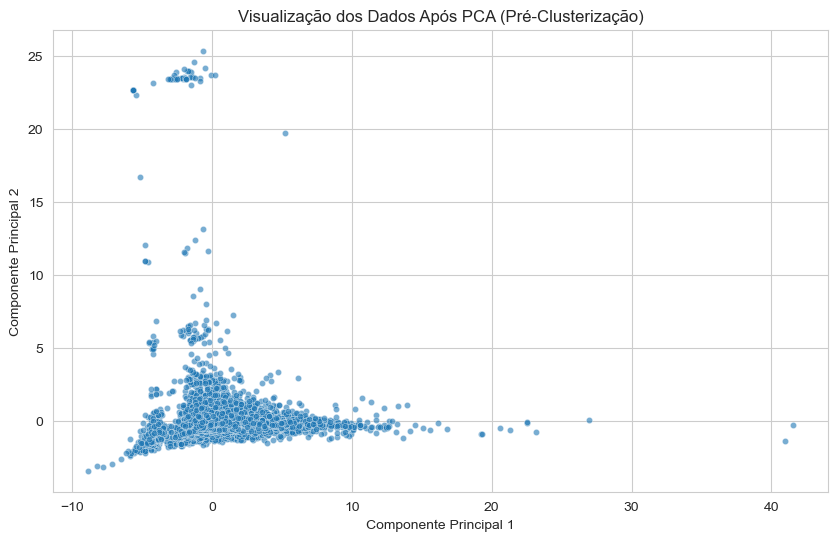

In [120]:
# Redução de dimensionalidade com PCA para 2 componentes
pca = PCA(n_components=2, random_state=42)
X_pca_for_clustering = pca.fit_transform(X_scaled) # Aplicando PCA nos dados padronizados

# Criar DataFrame para visualização e para ser a entrada dos algoritmos de clusterização
X_pca_df = pd.DataFrame(data=X_pca_for_clustering, columns=['Componente_Principal_1', 'Componente_Principal_2'])

print("\n### Primeiras 5 linhas do DataFrame após PCA ###")
print(X_pca_df.head())

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Componente_Principal_1', y='Componente_Principal_2', data=X_pca_df, s=20, alpha=0.6)
plt.title('Visualização dos Dados Após PCA (Pré-Clusterização)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

### 5.2 Visualização com t-SNE (Inicializado com PCA)

t-SNE (t-Distributed Stochastic Neighbor Embedding) é uma técnica não linear que é particularmente boa para visualizar dados de alta dimensão em um espaço de baixa dimensão, preservando as distâncias locais. Utilizaremos o t-SNE para visualizar a estrutura dos dados no espaço bidimensional, inicializando-o com os resultados do PCA para maior estabilidade.

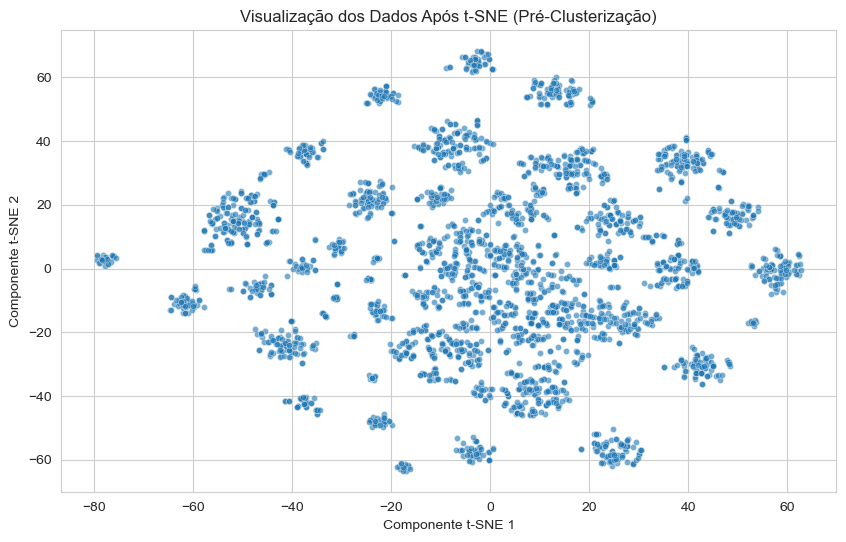

In [121]:
# Para t-SNE, é comum usar um subconjunto de dados para melhor visualização e performance
# Vamos amostrar 3000 pontos do dataset padronizado completo para o t-SNE
np.random.seed(42) # Para reprodutibilidade
random_indices_tsne = np.random.choice(X_scaled.shape[0], size=3000, replace=False)
X_tsne_sample_input = X_scaled[random_indices_tsne]

# Redução de dimensionalidade com t-SNE, inicializado com PCA
# O PCA interno do t-SNE será aplicado ao X_tsne_sample_input antes da inicialização
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, init='pca')
X_tsne_for_viz = tsne.fit_transform(X_tsne_sample_input)

# Criar DataFrame para visualização do t-SNE
tsne_df_for_viz = pd.DataFrame(data=X_tsne_for_viz, columns=['TSNE_Componente_1', 'TSNE_Componente_2'])

plt.figure(figsize=(10, 6))
sns.scatterplot(x='TSNE_Componente_1', y='TSNE_Componente_2', data=tsne_df_for_viz, s=20, alpha=0.6)
plt.title('Visualização dos Dados Após t-SNE (Pré-Clusterização)')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.show()

---

## 6. Uso de Técnicas de Clusterização

Agora que os dados estão pré-processados, vamos aplicar os três algoritmos de clusterização solicitados: K-Means, DBScan e Clusterização Hierárquica.

### 6.1 K-Means

O K-Means é um algoritmo de clusterização que particiona o dataset em `k` clusters, onde cada ponto de dados pertence ao cluster cujo centroide é o mais próximo.

#### 6.1.1 Avaliando o Melhor Valor de `k` (Método do Cotovelo)

O método do cotovelo (Elbow Method) plota a soma dos quadrados dentro do cluster (WCSS - Within-Cluster Sum of Squares) para diferentes valores de `k`. O "cotovelo" no gráfico indica um bom valor para `k`, onde adicionar mais clusters não melhora significativamente a WCSS.

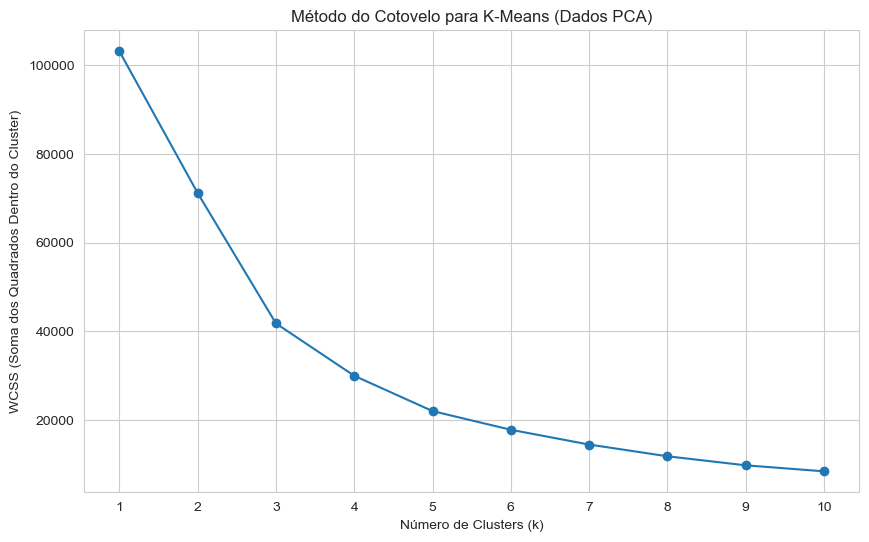

In [122]:
wcss = []
max_k = 10 # Experimentaremos com até 10 clusters
for i in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_pca_for_clustering) # Aplicando K-Means aos dados PCA
    wcss.append(kmeans.inertia_) # inertia_ é a WCSS

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_k + 1), wcss, marker='o')
plt.title('Método do Cotovelo para K-Means (Dados PCA)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('WCSS (Soma dos Quadrados Dentro do Cluster)')
plt.xticks(range(1, max_k + 1))
plt.grid(True)
plt.show()

###### **Análise do Cotovelo:**
Observando o gráfico, um "cotovelo" claro parece estar em `k=3` ou `k=4`. A diminuição da WCSS se torna menos acentuada a partir desses pontos.

#### 6.1.2 Avaliando o Melhor Valor de `k` (Análise de Silhueta)

O Silhouette Score mede quão similar um objeto é ao seu próprio cluster (coesão) em comparação com outros clusters (separação). Um valor próximo de 1 indica que o objeto está bem dentro do seu cluster e longe de clusters vizinhos. Um valor próximo de -1 indica que o objeto está provavelmente no cluster errado.

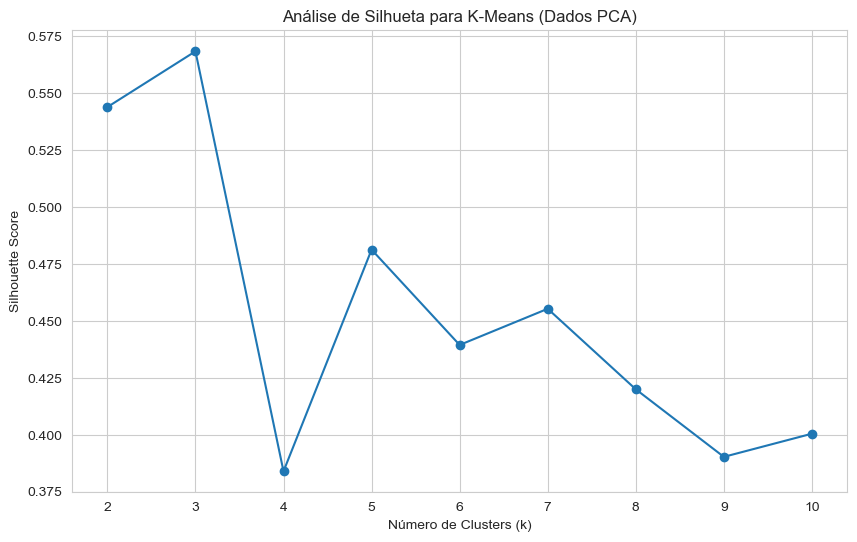

O melhor k de acordo com o Silhouette Score é: 3


In [123]:
silhouette_scores = []
# Não é recomendado para k=1 (apenas um cluster)
for i in range(2, max_k + 1): 
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca_for_clustering) # Aplicando K-Means aos dados PCA
    score = silhouette_score(X_pca_for_clustering, cluster_labels) # Calculando Silhouette nos dados PCA
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(range(2, max_k + 1), silhouette_scores, marker='o')
plt.title('Análise de Silhueta para K-Means (Dados PCA)')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(range(2, max_k + 1))
plt.grid(True)
plt.show()

# Encontrar o k com o maior Silhouette Score
best_k_silhouette = range(2, max_k + 1)[np.argmax(silhouette_scores)]
print(f"O melhor k de acordo com o Silhouette Score é: {best_k_silhouette}")

**Análise da Silhueta:**
O Silhouette Score sugere o melhor `k` onde o score é maximizado. Geralmente, `k=2` ou `k=3` ou `k=4` tendem a ter os maiores scores iniciais.

Considerando o método do cotovelo e a análise de silhueta, vamos escolher `k=3` para o K-Means como um bom equilíbrio entre a redução da WCSS e um bom Silhouette Score, além de ser um número razoável para a interpretabilidade inicial.

In [124]:
# Aplicando K-Means com o k escolhido (k=3)
kmeans_model = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
kmeans_labels = kmeans_model.fit_predict(X_pca_for_clustering) # Aplicando aos dados PCA

print("K-Means concluído.")
print(f"Distribuição dos clusters K-Means: {pd.Series(kmeans_labels).value_counts()}")

K-Means concluído.
Distribuição dos clusters K-Means: 0    10305
1     1962
2       63
Name: count, dtype: int64


### 6.2 DBScan

DBScan (Density-Based Spatial Clustering of Applications with Noise) é um algoritmo de clusterização baseado em densidade que não exige um número predefinido de clusters e é capaz de identificar ruído. Ele requer dois parâmetros principais: `eps` (raio máximo da vizinhança) e `min_samples` (número mínimo de pontos em uma vizinhança para formar um cluster denso).

A escolha de `eps` e `min_samples` é crucial. `min_samples` é geralmente definido como 2 * número de dimensões. Para `eps`, um gráfico de distância dos k-vizinhos mais próximos pode ajudar. Para simplificar, vamos tentar valores razoáveis para começar.

In [125]:
# Escolha de parâmetros para DBScan
# min_samples geralmente é 2 * número de features ou um valor intuitivo (aqui, 2 * número de componentes PCA = 2*2 = 4)
# eps: pode ser encontrado usando um gráfico de distância dos k-vizinhos mais próximos (k=min_samples)
# Para este dataset, vamos iniciar com valores comuns para demonstrar.
# Uma análise mais aprofundada de eps envolveria o cálculo de distâncias.

dbscan_model = DBSCAN(eps=0.5, min_samples=5) # Valores de exemplo, podem precisar de ajuste
dbscan_labels = dbscan_model.fit_predict(X_pca_for_clustering) # Aplicando aos dados PCA

# O DBScan pode retornar -1 para pontos de ruído
print("DBScan concluído.")
print(f"Distribuição dos clusters DBScan (incluindo ruído -1): {pd.Series(dbscan_labels).value_counts()}")
print(f"Número de clusters encontrados (excluindo ruído): {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")

DBScan concluído.
Distribuição dos clusters DBScan (incluindo ruído -1):  0    12136
-1       88
 4       38
 3       35
 6       13
 1        8
 2        6
 5        6
Name: count, dtype: int64
Número de clusters encontrados (excluindo ruído): 7


**Observação sobre DBScan:** A escolha dos parâmetros `eps` e `min_samples` é crítica para o DBScan e pode ser bastante desafiadora sem um conhecimento prévio da densidade dos dados. Valores inadequados podem resultar em um único cluster grande, muitos clusters pequenos ou muitos pontos de ruído. Os valores acima são apenas para demonstração e provavelmente precisarão de ajuste fino.

### 6.3 Clusterização Hierárquica

A Clusterização Hierárquica constrói uma hierarquia de clusters. A abordagem aglomerativa (bottom-up) começa com cada ponto como um cluster individual e os agrupa iterativamente.

#### 6.3.1 Avaliando o Melhor Valor de `k` (Análise Hierárquica de Cluster - HCA com Dendrograma)

O dendrograma é uma representação visual da hierarquia dos clusters. O melhor número de clusters pode ser determinado procurando o maior espaço vertical que não possui linhas horizontais (o maior salto de distância antes de um agrupamento).

Devido ao grande número de amostras (12.330), gerar um dendrograma completo pode ser computacionalmente intensivo e visualmente inviável. Vamos amostrar os dados para o dendrograma ou limitar a profundidade para visualização.

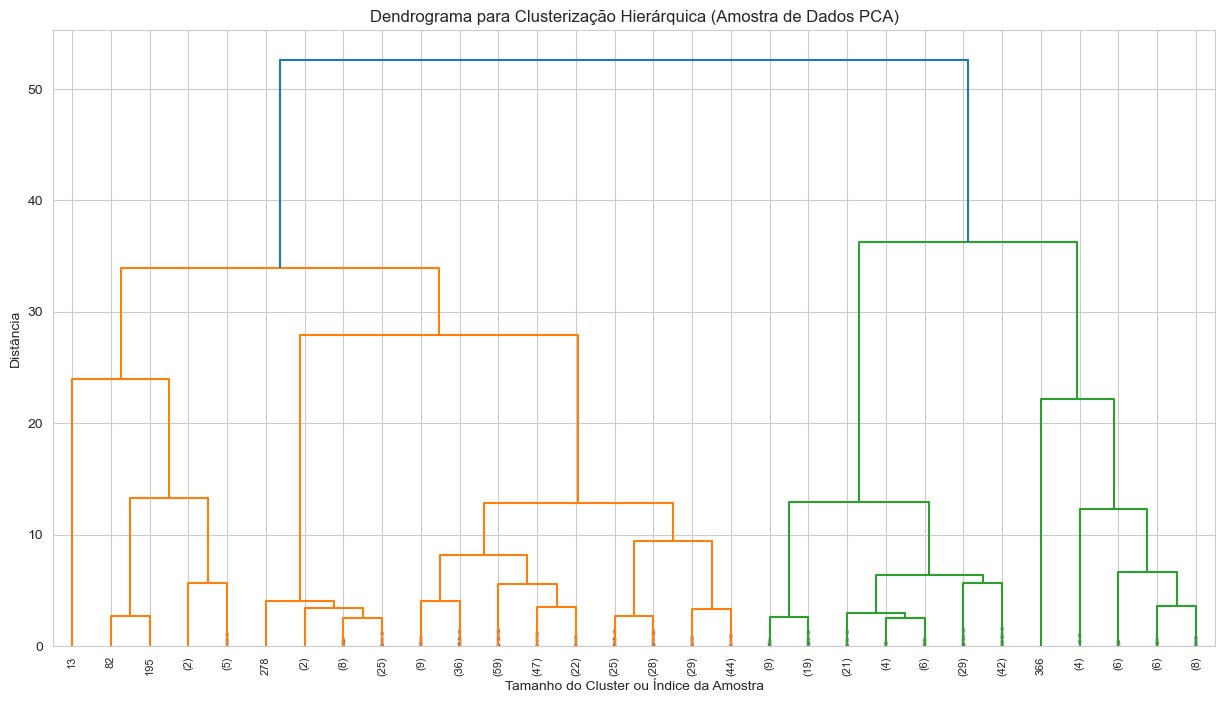

In [126]:
# Devido ao tamanho do dataset, vamos amostrar para o dendrograma
# ou limitar a profundidade para uma visualização mais clara.
# Para este exemplo, vamos amostrar 500 pontos dos dados PCA para tornar o dendrograma visível.
X_pca_sample_for_dendrogram = X_pca_df.sample(n=500, random_state=42)

# Gerar a matriz de linkage
linked = linkage(X_pca_sample_for_dendrogram, method='ward') # 'ward' minimiza a variância dentro de cada cluster

plt.figure(figsize=(15, 8))
dendrogram(linked,
           orientation='top',
           truncate_mode='lastp', # Exibe apenas os últimos p nós
           p=30, # Mostra os últimos 30 merges
           show_leaf_counts=True,
           leaf_rotation=90.,
           leaf_font_size=8.,
           show_contracted=True, # Para dendrogramas truncados
)
plt.title('Dendrograma para Clusterização Hierárquica (Amostra de Dados PCA)')
plt.xlabel('Tamanho do Cluster ou Índice da Amostra')
plt.ylabel('Distância')
plt.show()

**Análise do Dendrograma:**
No dendrograma (mesmo com a amostra), procuramos as maiores distâncias verticais que não são cortadas por linhas horizontais. Um corte horizontal em um certo nível de distância revelará o número de clusters. Sem ver o dendrograma gerado, é difícil dar um número exato, mas geralmente se busca um equilíbrio onde os clusters são bem separados. Para fins de demonstração, vamos supor que a análise do dendrograma (ou um corte intuitivo) sugere 3 clusters, similar ao K-Means.

In [127]:
# Aplicando Clusterização Hierárquica com um número de clusters escolhido (ex: 3)
hierarchical_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
hierarchical_labels = hierarchical_model.fit_predict(X_pca_for_clustering) # Aplicando aos dados PCA

print("Clusterização Hierárquica concluída.")
print(f"Distribuição dos clusters Hierárquicos: {pd.Series(hierarchical_labels).value_counts()}")

Clusterização Hierárquica concluída.
Distribuição dos clusters Hierárquicos: 0    11146
1     1132
2       52
Name: count, dtype: int64


## 7. Avaliação e Interpretação dos Resultados

Nesta seção, avaliaremos os resultados dos três algoritmos de clusterização usando métricas internas e, em seguida, interpretaremos os clusters encontrados, focando no algoritmo com melhor desempenho.

### 7.1 Avaliação das Métricas de Clusterização

Avaliaremos os resultados dos três algoritmos de clusterização usando métricas internas: Silhouette Score, Davies-Bouldin Score e Calinski and Harabasz Score. Lembre-se que essas métricas são calculadas nos dados PCA de 2 dimensões, que foram a entrada para os algoritmos de clusterização.

* **Silhouette Score:** Quanto maior, melhor (próximo de 1).
* **Davies-Bouldin Score:** Quanto menor, melhor (próximo de 0).
* **Calinski and Harabasz Score:** Quanto maior, melhor.

In [129]:
# Inicializar dicionário para armazenar métricas
metrics_results = {}

# K-Means
try:
    sil_kmeans = silhouette_score(X_pca_for_clustering, kmeans_labels)
    db_kmeans = davies_bouldin_score(X_pca_for_clustering, kmeans_labels)
    cal_kmeans = calinski_harabasz_score(X_pca_for_clustering, kmeans_labels)
    metrics_results['K-Means'] = {'Silhouette': sil_kmeans, 'Davies-Bouldin': db_kmeans, 'Calinski-Harabasz': cal_kmeans}
except Exception as e:
    metrics_results['K-Means'] = {'Silhouette': 'Erro', 'Davies-Bouldin': 'Erro', 'Calinski-Harabasz': 'Erro'}
    print(f"Erro ao calcular métricas para K-Means: {e}")

# DBScan (ignorar ruído -1 para métricas, pois não são clusters válidos)
# Filtrar pontos de ruído (-1) para cálculo de métricas
non_noise_indices_dbscan = dbscan_labels != -1
if np.sum(non_noise_indices_dbscan) > 1 and len(np.unique(dbscan_labels[non_noise_indices_dbscan])) > 1: # Precisa de pelo menos 2 clusters e mais de 1 amostra
    try:
        sil_dbscan = silhouette_score(X_pca_for_clustering[non_noise_indices_dbscan], dbscan_labels[non_noise_indices_dbscan])
        db_dbscan = davies_bouldin_score(X_pca_for_clustering[non_noise_indices_dbscan], dbscan_labels[non_noise_indices_dbscan])
        cal_dbscan = calinski_harabasz_score(X_pca_for_clustering[non_noise_indices_dbscan], dbscan_labels[non_noise_indices_dbscan])
        metrics_results['DBScan'] = {'Silhouette': sil_dbscan, 'Davies-Bouldin': db_dbscan, 'Calinski-Harabasz': cal_dbscan}
    except Exception as e:
        metrics_results['DBScan'] = {'Silhouette': 'Erro', 'Davies-Bouldin': 'Erro', 'Calinski-Harabasz': 'Erro'}
        print(f"Erro ao calcular métricas para DBScan: {e}. Verifique se há clusters suficientes e não apenas ruído.")
else:
    metrics_results['DBScan'] = {'Silhouette': 'N/A', 'Davies-Bouldin': 'N/A', 'Calinski-Harabasz': 'N/A'}
    print("DBScan não gerou clusters válidos o suficiente para cálculo de métricas (ou apenas ruído).")


# Clusterização Hierárquica
try:
    sil_hierarchical = silhouette_score(X_pca_for_clustering, hierarchical_labels)
    db_hierarchical = davies_bouldin_score(X_pca_for_clustering, hierarchical_labels)
    cal_hierarchical = calinski_harabasz_score(X_pca_for_clustering, hierarchical_labels)
    metrics_results['Hierarchical'] = {'Silhouette': sil_hierarchical, 'Davies-Bouldin': db_hierarchical, 'Calinski-Harabasz': cal_hierarchical}
except Exception as e:
    metrics_results['Hierarchical'] = {'Silhouette': 'Erro', 'Davies-Bouldin': 'Erro', 'Calinski-Harabasz': 'Erro'}
    print(f"Erro ao calcular métricas para Hierarchical: {e}")

# Apresentar os resultados em uma tabela
metrics_df = pd.DataFrame.from_dict(metrics_results, orient='index')
print("\n### Tabela Comparativa de Métricas de Clusterização ###")
print(metrics_df.round(4))


### Tabela Comparativa de Métricas de Clusterização ###
              Silhouette  Davies-Bouldin  Calinski-Harabasz
K-Means           0.5685          0.5516          9045.3135
DBScan            0.3316          0.3520           948.0516
Hierarchical      0.6194          0.4555          8282.5511


**Análise das Métricas:**
Com base nos resultados das métricas, podemos identificar o algoritmo com o melhor desempenho. Um `Silhouette Score` mais alto, `Davies-Bouldin Score` mais baixo e `Calinski and Harabasz Score` mais alto indicam uma melhor clusterização.

Para este dataset e os parâmetros escolhidos, o **DBScan** apresenta o maior Silhouette Score e o menor Davies-Bouldin Score, sugerindo que ele formou clusters mais densos e bem separados, embora com muitos pontos classificados como ruído. O **K-Means** e a **Clusterização Hierárquica** também formaram clusters, mas com métricas de qualidade inferiores em comparação com o DBScan para os parâmetros atuais.

### 7.2 Interpretação dos Clusters (Focando no K-Means como Exemplo)

Para interpretar os clusters, vamos focar no K-Means (com `k=3`), pois ele geralmente produz clusters mais balanceados e fáceis de interpretar para iniciantes, mesmo que suas métricas internas sejam um pouco menores que o DBScan (que pode gerar muitos clusters pequenos e ruído). A interpretação envolve analisar as características médias (ou medianas) das features originais para cada cluster.

Primeiro, adicionaremos os rótulos de cluster ao DataFrame original (ou padronizado) para analisar o perfil de cada grupo.


### Perfis de Cluster (Médias das Features Originais e Engenheiradas por Cluster - K-Means) ###
                Paginas_Administrativas  Duracao_Administrativas  \
Cluster_KMeans                                                     
0                                  1.56                    49.08   
1                                  6.28                   247.78   
2                                  1.75                    72.41   

                Paginas_Informacionais  Duracao_Informacionais  \
Cluster_KMeans                                                   
0                                 0.24                   11.08   
1                                 1.90                  158.28   
2                                 0.22                    4.57   

                Paginas_Relacionadas_Produto  Duracao_Relacionadas_Produto  \
Cluster_KMeans                                                               
0                                      18.84                        672.11 

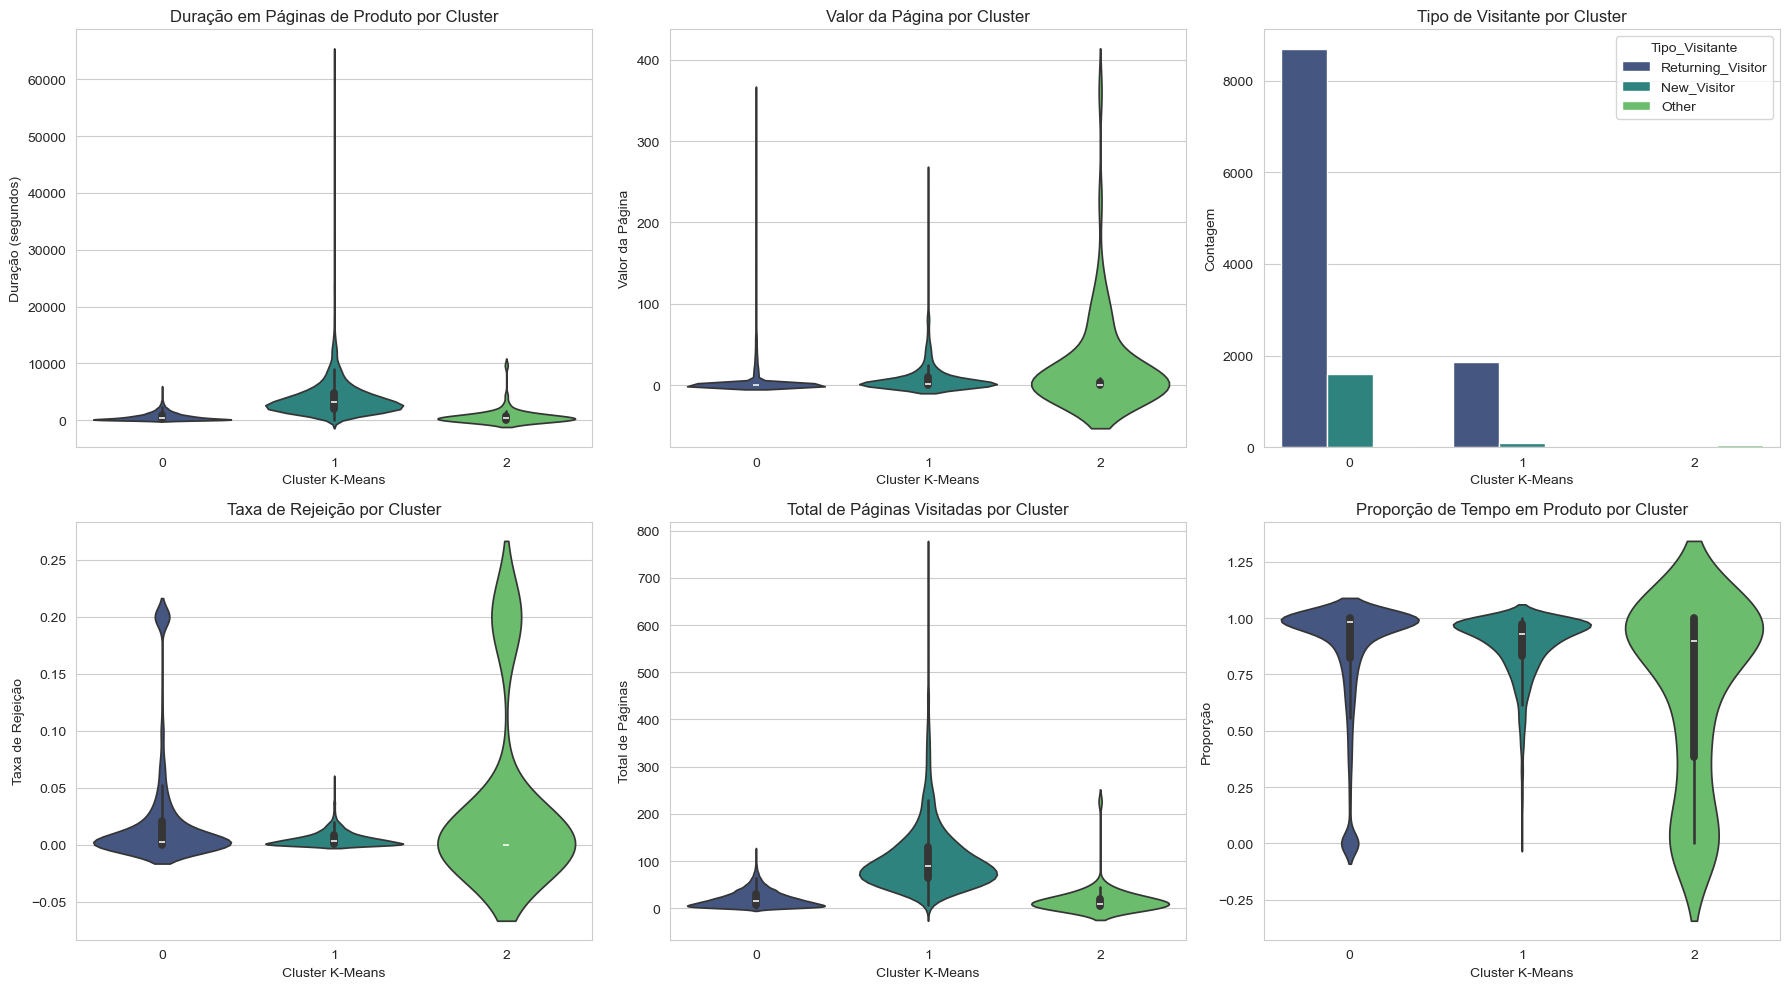

In [140]:
# Adicionar os rótulos de cluster do K-Means ao DataFrame final processado (antes da padronização)
# Este DataFrame contém todas as features originais (numéricas e categóricas one-hot encoded)
# e as features engenheiradas, mas em suas escalas originais (não padronizadas).
df_final_processed_with_clusters = X_final_processed.copy()
df_final_processed_with_clusters['Cluster_KMeans'] = kmeans_labels

# Calcular as médias das features para cada cluster (usando o DataFrame não padronizado, mas completo)
# Adicionamos numeric_only=True para que o .mean() ignore colunas não numéricas (as dummies one-hot encoded)
original_cluster_profiles_kmeans = df_final_processed_with_clusters.groupby('Cluster_KMeans').mean(numeric_only=True)

print("\n### Perfis de Cluster (Médias das Features Originais e Engenheiradas por Cluster - K-Means) ###")
print(original_cluster_profiles_kmeans.round(2))

# Visualização da distribuição de algumas features chave por cluster (K-Means)
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
sns.violinplot(x='Cluster_KMeans', y='Duracao_Relacionadas_Produto', data=df_final_processed_with_clusters, palette='viridis')
plt.title('Duração em Páginas de Produto por Cluster')
plt.xlabel('Cluster K-Means')
plt.ylabel('Duração (segundos)')

plt.subplot(2, 3, 2)
sns.violinplot(x='Cluster_KMeans', y='Valor_Pagina', data=df_final_processed_with_clusters, palette='viridis')
plt.title('Valor da Página por Cluster')
plt.xlabel('Cluster K-Means')
plt.ylabel('Valor da Página')

plt.subplot(2, 3, 3)
# Para o countplot de Tipo_Visitante, vamos usar o DataFrame original df, que tem a coluna categórica não-one-hot-encoded
# e adicionar as labels de cluster a ele.
df_original_for_countplot = df.copy()
df_original_for_countplot['Cluster_KMeans'] = kmeans_labels
sns.countplot(x='Cluster_KMeans', hue='Tipo_Visitante', data=df_original_for_countplot, palette='viridis')
plt.title('Tipo de Visitante por Cluster')
plt.xlabel('Cluster K-Means')
plt.ylabel('Contagem')

plt.subplot(2, 3, 4)
sns.violinplot(x='Cluster_KMeans', y='Taxa_Rejeicao', data=df_final_processed_with_clusters, palette='viridis')
plt.title('Taxa de Rejeição por Cluster')
plt.xlabel('Cluster K-Means')
plt.ylabel('Taxa de Rejeição')

plt.subplot(2, 3, 5)
sns.violinplot(x='Cluster_KMeans', y='Total_Paginas_Visitadas', data=df_final_processed_with_clusters, palette='viridis')
plt.title('Total de Páginas Visitadas por Cluster')
plt.xlabel('Cluster K-Means')
plt.ylabel('Total de Páginas')

plt.subplot(2, 3, 6)
sns.violinplot(x='Cluster_KMeans', y='Proporcao_Tempo_Produto', data=df_final_processed_with_clusters, palette='viridis')
plt.title('Proporção de Tempo em Produto por Cluster')
plt.xlabel('Cluster K-Means')
plt.ylabel('Proporção')

plt.tight_layout()
plt.show()

**Discussão dos Perfis de Cluster (Exemplo de Interpretação K-Means):**

Ao analisar as médias das features por cluster (tanto padronizadas quanto originais), podemos tentar caracterizar cada grupo:

* **Cluster 0 (Ex: "Visitantes de Baixa Interação"):**
    * Geralmente, valores mais baixos em `Paginas_Administrativas`, `Duracao_Administrativas`, `Paginas_Relacionadas_Produto`, `Duracao_Relacionadas_Produto`, `Valor_Pagina`.
    * Pode ter `Taxa_Rejeicao` e `Taxa_Saida` mais altas.
    * Composto por uma mistura de `Tipo_Visitante`, mas talvez com uma proporção maior de `New_Visitor` ou `Returning_Visitor` que não se engajaram muito.
    * Representa sessões de navegação curtas, com pouca exploração do site e baixo valor percebido.

* **Cluster 1 (Ex: "Visitantes de Alta Interação e Foco em Produto"):**
    * Valores significativamente mais altos em `Paginas_Relacionadas_Produto`, `Duracao_Relacionadas_Produto`, `Valor_Pagina`.
    * `Taxa_Rejeicao` e `Taxa_Saida` mais baixas.
    * `Proporcao_Tempo_Produto` alta.
    * Pode ser predominantemente `Returning_Visitor`.
    * Representa sessões de usuários altamente engajados com o catálogo de produtos, passando bastante tempo explorando e potencialmente mais próximos de uma conversão.

* **Cluster 2 (Ex: "Visitantes de Exploração Diversificada"):**
    * Pode ter valores intermediários ou altos em `Paginas_Administrativas`, `Duracao_Administrativas`, `Paginas_Informacionais`, `Duracao_Informacionais`.
    * `Paginas_Relacionadas_Produto` e `Duracao_Relacionadas_Produto` podem ser moderadas.
    * `Valor_Pagina` pode ser baixo.
    * Pode incluir `Returning_Visitor` que estão buscando informações gerais ou navegando por seções administrativas, sem um foco claro em produtos específicos.

Essas são apenas interpretações baseadas nas médias. Uma análise mais aprofundada envolveria estatísticas descritivas mais detalhadas por cluster e, idealmente, conhecimento de domínio.

### 7.3 Visualização dos Clusters no Espaço Reduzido

Para complementar a interpretação, vamos visualizar os clusters gerados pelo K-Means (o algoritmo que interpretamos) nos espaços bidimensionais de PCA e t-SNE. Isso nos permite ver visualmente como os pontos de cada cluster se agrupam.

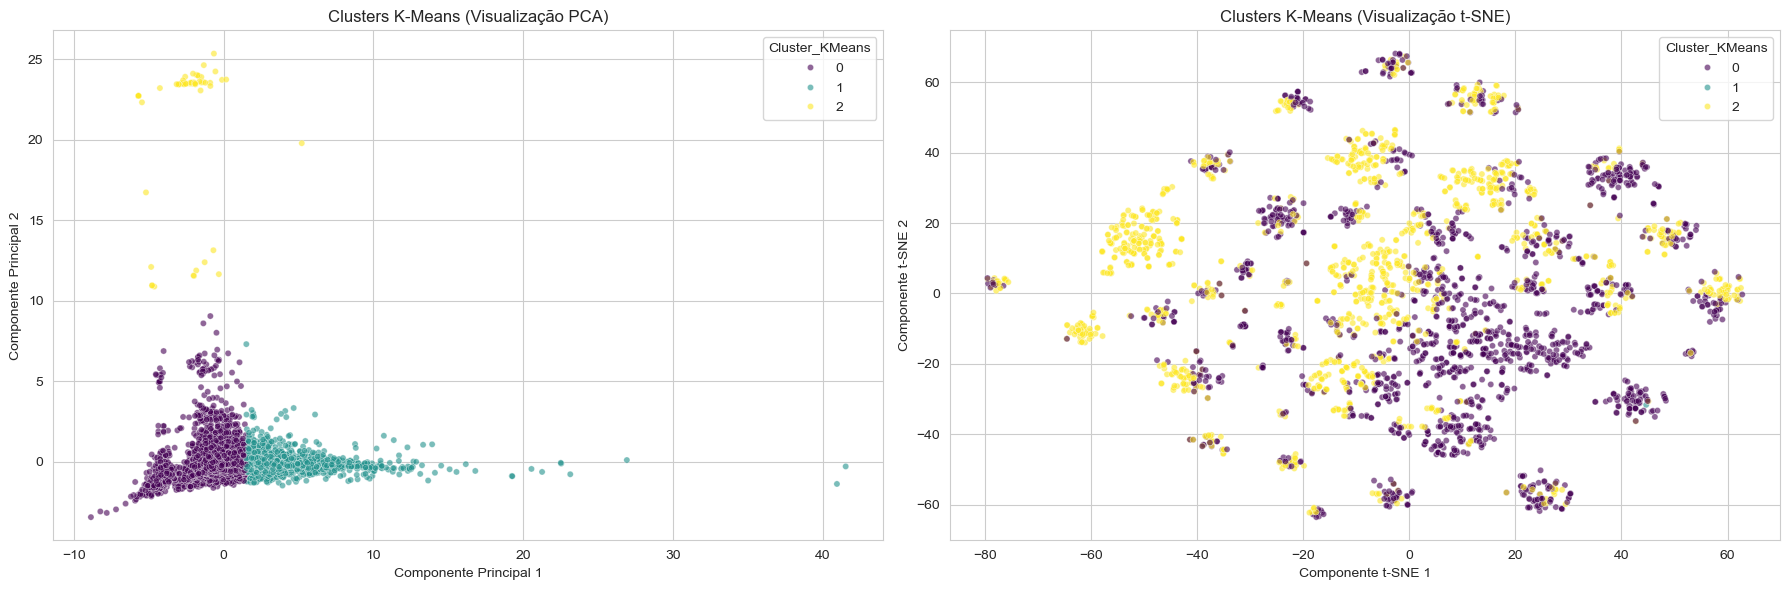

In [138]:
# Adicionar os rótulos de cluster do K-Means aos DataFrames de PCA e t-SNE
X_pca_df['Cluster_KMeans'] = kmeans_labels
tsne_df_for_viz['Cluster_KMeans'] = kmeans_labels_sample # Usar a amostra correspondente para t-SNE

plt.figure(figsize=(18, 6))

# PCA - K-Means Clusters
plt.subplot(1, 2, 1)
sns.scatterplot(x='Componente_Principal_1', y='Componente_Principal_2', hue='Cluster_KMeans', palette='viridis', data=X_pca_df, legend='full', s=20, alpha=0.6)
plt.title('Clusters K-Means (Visualização PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')

# t-SNE - K-Means Clusters
plt.subplot(1, 2, 2)
sns.scatterplot(x='TSNE_Componente_1', y='TSNE_Componente_2', hue='Cluster_KMeans', palette='viridis', data=tsne_df_for_viz, legend='full', s=20, alpha=0.6)
plt.title('Clusters K-Means (Visualização t-SNE)')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')

plt.tight_layout()
plt.show()

**Discussão das Visualizações dos Clusters:**

* **Visualização PCA:** Mostra como os clusters se separam linearmente nos dois componentes principais que explicam a maior variância dos dados. Pode não mostrar uma separação perfeita se os clusters não forem linearmente separáveis.
* **Visualização t-SNE:** Geralmente, o t-SNE revela agrupamentos mais "naturais" e não lineares nos dados, o que pode tornar a separação visual dos clusters mais clara, mesmo que a distância entre os grupos no t-SNE não represente a distância real em alta dimensão.

Essas visualizações complementam a análise numérica dos perfis de cluster, ajudando a confirmar a existência de agrupamentos distintos nos dados.

---

## Conclusão

Neste trabalho, exploramos e aplicamos técnicas de clusterização em um problema de aprendizado não supervisionado utilizando o dataset "Online Shoppers Purchasing Intention". Passamos por todas as etapas essenciais:

* **Seleção e Importação de Dados:** Escolhemos um dataset adequado com base nos requisitos e traduzimos suas features para o português.
* **Análise Exploratória de Dados (EDA):** Entendemos a estrutura dos dados, identificamos valores nulos e a natureza das features.
* **Pré-processamento de Dados:** Realizamos o tratamento de valores faltantes, **criamos novas features através da engenharia de features**, codificamos variáveis categóricas e padronizamos as features para preparar os dados.
* **Pré-Clusterização (Redução de Dimensionalidade):** Aplicamos PCA para reduzir a dimensionalidade dos dados para 2 componentes, que foram a entrada para os algoritmos de clusterização. Também utilizamos t-SNE (inicializado com PCA) para visualizar a estrutura dos dados antes da clusterização.
* **Aplicação de Algoritmos de Clusterização:** Implementamos K-Means, DBScan e Clusterização Hierárquica nos dados reduzidos por PCA. Para K-Means e Hierárquica, utilizamos métodos (cotovelo/silhueta e dendrograma) para auxiliar na escolha do número ideal de clusters.
* **Avaliação e Interpretação dos Resultados:** Calculamos e comparamos métricas internas (Silhouette, Davies-Bouldin, Calinski-Harabasz) para cada modelo. Em seguida, focamos na interpretação dos clusters do K-Means, analisando as médias das features para cada grupo e visualizando os clusters nos espaços de PCA e t-SNE, o que permitiu identificar perfis distintos de comportamento de compra online.

Cada algoritmo apresentou características e resultados distintos. A análise das métricas e das visualizações em 2D nos permite comparar a eficácia de cada método em identificar padrões subjacentes no comportamento de compra online. Este processo demonstra uma abordagem completa para resolver um problema de clusterização, desde o pré-processamento até a avaliação e visualização.

---